# Modelo 2 - Voting Classifier

En este segundo Notebook se presenta la construcción de dos modelos de prueba de [Voting Classifier](https://www.geeksforgeeks.org/voting-classifier/), para identificar si con la combinación de varios modelos más sencillos puede mejorar la precisión.

El documento está organizado de la siguiente manera:

1. Carga de la información
2. **Modelo 1:** KNN, Regresión Logística y Bosque Aleatorio (Random Forest)
3. **Modelo 2:** Random Forest, XGBoost y Adaboost Classifier
4. Comentarios finales

# 1. Cargado de Base

Para este ejercicio se utilizó la base de **CIC-DDoS2019**, que se carga a continuación junto con las demas librerías que se utilizaron en el ejercicio:

In [ ]:
# Montado de drive para realizar el análisis
from google.colab import drive
drive.mount('/content/drive')
#Librerías Utilizadas
import pandas as pd # Manipulación de datos
pd.options.display.float_format = '{:.1f}'.format # Adecuar formato de salidas de tablas a 1 posición decimal
import seaborn as sns # Creación de gráficas
import matplotlib.pyplot as plt # Formato de gráficas
import numpy as np
# Herramientas de análisis de modelos
from sklearn.model_selection import train_test_split, GridSearchCV # Creación set entrenamiento - validación
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score # Medición de precisión
from sklearn.preprocessing import LabelEncoder
# Librerías modelo XGbost
from xgboost import XGBClassifier # Modelo a entrenar
from xgboost import plot_importance # Gráfica para ver pesos de las variables

Mounted at /content/drive


Con estas librerías se realizó el cargue de la información, que corresponde a 431371 filas y 39 columnas y donde no hay valores nulos:

In [ ]:
df_CIC2019_corr = pd.read_parquet("/content/drive/MyDrive/Tesis - Machine Learning/Tesis - Machine Learning/E - Modelo predicción/Base/CICIDS2019_2.parquet")

In [ ]:
df_CIC2019_corr.head(5)

,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Fwd Packets Length Total,Bwd Packets Length Total,Flow Bytes/s,Flow Packets/s,Fwd PSH Flags,Fwd Header Length,...,Fwd Seg Size Min,Label,Packet Length Mean,Fwd Packet Length Mean,Active Mean,Fwd IAT Mean,Idle Mean,Bwd IAT Mean,Bwd Packet Length Mean,Flow IAT Mean
0,17,48,4,0,1616.0,0.0,33666666.7,83333.3,0,80,...,20,DrDoS_NTP,411.2,404.0,0.0,16.0,0.0,0.0,0.0,16.0
1,17,557,112,0,49280.0,0.0,88473967.7,201077.2,0,0,...,0,DrDoS_NTP,440.0,440.0,0.0,5.0,0.0,0.0,0.0,5.0
2,6,323228,14,12,1736.0,526.0,6998.2,80.4,0,304,...,20,Benign,83.8,124.0,0.0,24863.7,0.0,15038.7,43.8,12929.1
3,17,46917,2,2,86.0,118.0,4348.1,85.3,0,40,...,20,Benign,49.4,43.0,0.0,3.0,0.0,2.0,59.0,15639.0
4,17,254,58,0,25520.0,0.0,100472440.9,228346.5,0,-58,...,-1,DrDoS_NTP,440.0,440.0,0.0,4.5,0.0,0.0,0.0,4.5


In [ ]:
# Revisión de Valores Nulos
df_CIC2019_corr.isna().sum().sort_values(ascending=False)

Protocol                    0
Fwd Seg Size Min            0
Subflow Fwd Packets         0
Subflow Fwd Bytes           0
Subflow Bwd Packets         0
Subflow Bwd Bytes           0
Init Fwd Win Bytes          0
Init Bwd Win Bytes          0
Fwd Act Data Packets        0
Label                       0
Avg Fwd Segment Size        0
Packet Length Mean          0
Fwd Packet Length Mean      0
Active Mean                 0
Fwd IAT Mean                0
Idle Mean                   0
Bwd IAT Mean                0
Bwd Packet Length Mean      0
Avg Bwd Segment Size        0
Avg Packet Size             0
Flow Duration               0
Fwd Header Length           0
Total Fwd Packets           0
Total Backward Packets      0
Fwd Packets Length Total    0
Bwd Packets Length Total    0
Flow Bytes/s                0
Flow Packets/s              0
Fwd PSH Flags               0
Bwd Header Length           0
Down/Up Ratio               0
Fwd Packets/s               0
Bwd Packets/s               0
SYN Flag C

# 2. Modelo 1

Como punto de referencia, se crearon los dataset de entrenamiento y validación para esta base, con una proporción de 80-20:


In [ ]:
from sklearn.preprocessing import normalize
# Variables a entrenar - Normalizadas
X1 = normalize(df_CIC2019_corr.drop(columns="Label"))
# Variable objetivo - sospechosos
le = LabelEncoder()
#Conversión de texto a numero (XGBOOST no funciona con variables tipo STRING)
encoded = le.fit_transform(df_CIC2019_corr["Label"])
y = encoded
# División entrenamiento - rest con ratio de 80% - 20%
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)

Posteriormente, se escogieron los siguientes 3 modelos, cada uno correspondiente a un tipo de modelo de Machine Learning:

* **Logistic Regression:** Modelo de Regresión Lineal
* **Random Forest:** Modelo de Bosque aleatorio con los valores predeterminados
* **KNN:** Modelo de vecinos más cercanos

In [ ]:
# Listado de Estimadores
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
# Creación de estimador 1 en una lista
estimador = []
estimador.append(('LogisticRegression', LogisticRegression(max_iter = 500)))
estimador.append(('RandomForest', RandomForestClassifier() ))
estimador.append(('KNN', KNeighborsClassifier() ))

Para tener un punto de referencia, se entrenó cada modelo por separado. Además, de acuerdo con los análisis previos, se normalizaron los datos para disminuir el efecto de los valores atípicos en la predicción de los modelos diferentes a los basados en árboles:

In [ ]:
import time
predictions_df = pd.DataFrame()
for i,j in estimador:
  inicio = time.time()
  model=j
  model.fit(X_train, y_train)
  predictions = model.predict(X_test)
  predictions_df[i] = predictions
  print(i," :" ,accuracy_score(y_test, predictions))
  final = time.time()
  ejecucion = final - inicio
  print(f"Tiempo de ejecución: {ejecucion} segundos")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression  : 0.8525297015357868
Tiempo de ejecución: 119.03530502319336 segundos
RandomForest  : 0.9800521587945523
Tiempo de ejecución: 132.28424215316772 segundos
KNN  : 0.9757055925818603
Tiempo de ejecución: 172.36080193519592 segundos


Como se evidencia, el modelo de Regresión Logística tiene la menor precisión, cerca del 85%, mientras que tanto el de Random Forest como el de KNN tienen una precisión de más del 90%. Con esto en cuenta, se construyó el modelo de clasificación por Votación de forma "soft", es decir, a partir del promedio de predicción de cada uno de los modelos para evidenciar si hay algún tipo de mejoría:

In [ ]:
%%time
VC_soft = VotingClassifier(estimators = estimador, voting ='soft')
VC_soft.fit(X_train, y_train)
y_pred = VC_soft.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: user 9min 8s, sys: 1min 9s, total: 10min 18s
Wall time: 7min 2s


A continuación se presenta el resumen de las métricas para cada ataque, evidenciando que tienen menor volumetría (Columna `support`) son las que tienen menores valores de precisión, recall y f1-score:

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19542
           1       0.67      0.39      0.49       771
           2       0.99      1.00      0.99     24236
           3       0.73      0.60      0.66       526
           4       0.62      0.73      0.67       718
           5       0.88      0.97      0.92      2906
           6       0.64      0.70      0.67       257
           7       0.65      0.32      0.43       153
           8       0.99      0.99      0.99      9857
           9       1.00      1.00      1.00     19791
          10       0.98      0.95      0.97      7504
          11       0.00      0.00      0.00        14

    accuracy                           0.98     86275
   macro avg       0.76      0.72      0.73     86275
weighted avg       0.98      0.98      0.98     86275



Para validar los resultados, se obtuvieron las métricas de análisis por separado. En estas métricas, se identificó que el modelo tuvo un peor desempeño en comparación con el modelo de Random Forest por separado. Esto muestra que la combinación de varios tipos de modelo no siempre implica una mejor precisión.

In [ ]:
y_model = VC_soft.predict(X_test)
#Precisión
acc = accuracy_score(y_test,y_model)
print(f"Precisión: {acc}")
#Recall
rec = recall_score(y_test,y_model, average= "weighted") # Parametro weighted para calcular de acuerdo con cantidad
print(f"Recall: {rec}")
# F1 - Score
f1 = f1_score(y_test,y_model, average= "weighted") # Parametro weighted para calcular de acuerdo con cantidad
print(f"F1 score: {f1}")

Precisión: 0.9787076209794262
Recall: 0.9787076209794262
F1 score: 0.9775970770390191


Como complemento, se construyó la matriz de confusión, que es similar a la obtenida en el modelo de prueba de XGBoost del notebook anterior, con una mejor precisión para los tipos de ataque con mayor número de registros:

<Axes: >

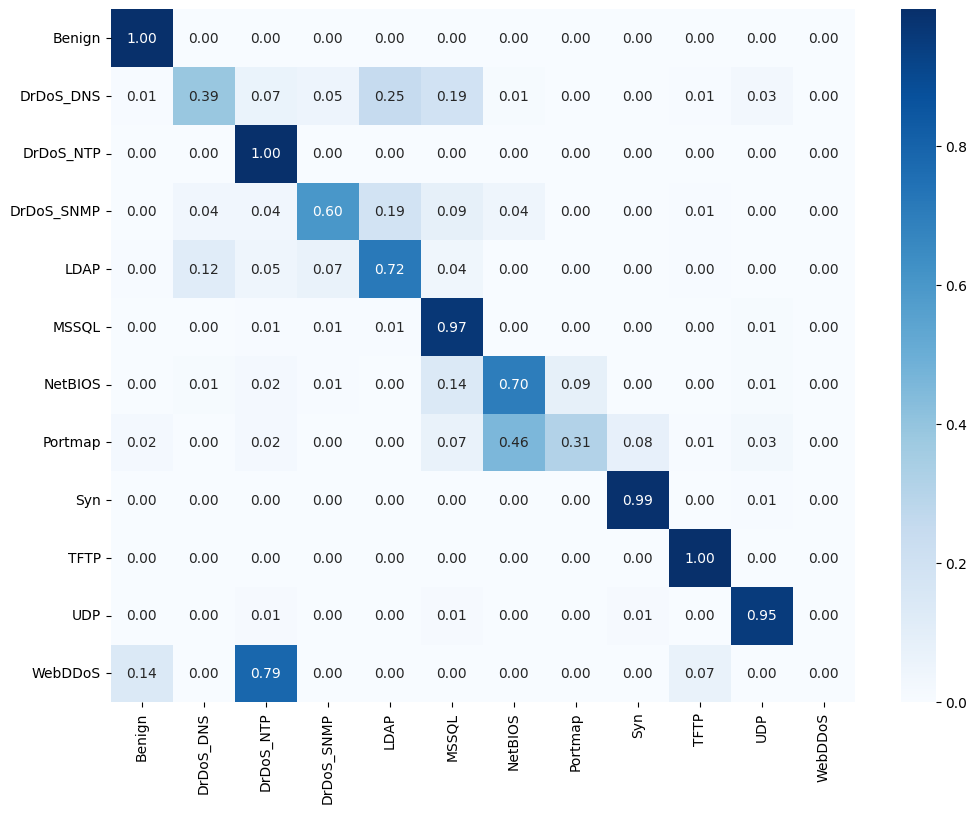

In [ ]:
# Matriz Normalizada
plt.figure(figsize=(12,9))
cm=confusion_matrix(y_test, y_model)
# Proceso de normalización
cm_normalized= cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized,annot=True, fmt=".2f", cmap="Blues", xticklabels=le.classes_,yticklabels=le.classes_)

# 3. Modelo 2

El ejercicio se repitió para los siguientes modelos:

* **XGBoost:** Modelo con mejor precisión y desempeño con respecto a los demás
* **Random Forest:** Modelo de mejor desempeño de prueba anterior
* **Adaboost:** Modelo de arbol para comparar otros puntos de mejora

In [ ]:
# Creación de lista con estimadores
estimador2 = []
estimador2.append(('RandomForest', RandomForestClassifier() ))
estimador2.append(('XGB', XGBClassifier(tree_method = "hist", device = "cuda") ))
estimador2.append(('AdaBoostClassifier', AdaBoostClassifier() ))

Al evaluar los modelos por separado, se identificó que los modelos de Random Forest y de XGBoost alcanzan una precisión cercana al 98% mientras que en el de AdaBoost es igual a 75%.

In [ ]:
for i,j in estimador2:
  inicio = time.time()
  model=j
  model.fit(X_train, y_train)
  predictions = model.predict(X_test)
  predictions_df[i] = predictions
  print(i," :" ,accuracy_score(y_test, predictions))
  final = time.time()
  ejecucion = final - inicio
  print(f"Tiempo de ejecución: {ejecucion} segundos")

RandomForest  : 0.9799594320486815
Tiempo de ejecución: 130.23930597305298 segundos


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [16:33:34] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


XGB  : 0.9818487394957983
Tiempo de ejecución: 9.569921493530273 segundos
AdaBoostClassifier  : 0.7490002897710808
Tiempo de ejecución: 63.54382014274597 segundos


Luego, al entrenar el modelo se identifica que la precisión y demás parámetros son ligeramente menores a los obtenidos por el modelo de XGBoost por si solo:

In [ ]:
%%time
VC_soft = VotingClassifier(estimators = estimador2, voting ='soft')
VC_soft.fit(X_train, y_train)
y_pred = VC_soft.predict(X_test)

CPU times: user 3min 22s, sys: 2.25 s, total: 3min 25s
Wall time: 3min 26s


In [ ]:
y_model = VC_soft.predict(X_test)
#Precisión
acc = accuracy_score(y_test,y_model)
print(f"Precisión: {acc}")
#Recall
rec = recall_score(y_test,y_model, average= "weighted") # Parametro weighted para calcular de acuerdo con cantidad
print(f"Recall: {rec}")
# F1 - Score
f1 = f1_score(y_test,y_model, average= "weighted") # Parametro weighted para calcular de acuerdo con cantidad
print(f"F1 score: {f1}")

Precisión: 0.9815937409446537
Recall: 0.9815937409446537
F1 score: 0.9807986148533306


Los valores de desempeño son similares a los obtenidos en el primer modelo de votación, tanto en las métricas principales como en la matriz de confusión

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     19542
           1       0.69      0.38      0.49       771
           2       1.00      1.00      1.00     24236
           3       0.63      0.74      0.68       526
           4       0.64      0.70      0.67       718
           5       0.88      0.96      0.92      2906
           6       0.64      0.74      0.69       257
           7       0.70      0.35      0.46       153
           8       1.00      0.99      0.99      9857
           9       1.00      1.00      1.00     19791
          10       0.98      0.97      0.98      7504
          11       0.14      0.07      0.10        14

    accuracy                           0.98     86275
   macro avg       0.77      0.74      0.75     86275
weighted avg       0.98      0.98      0.98     86275



<Axes: >

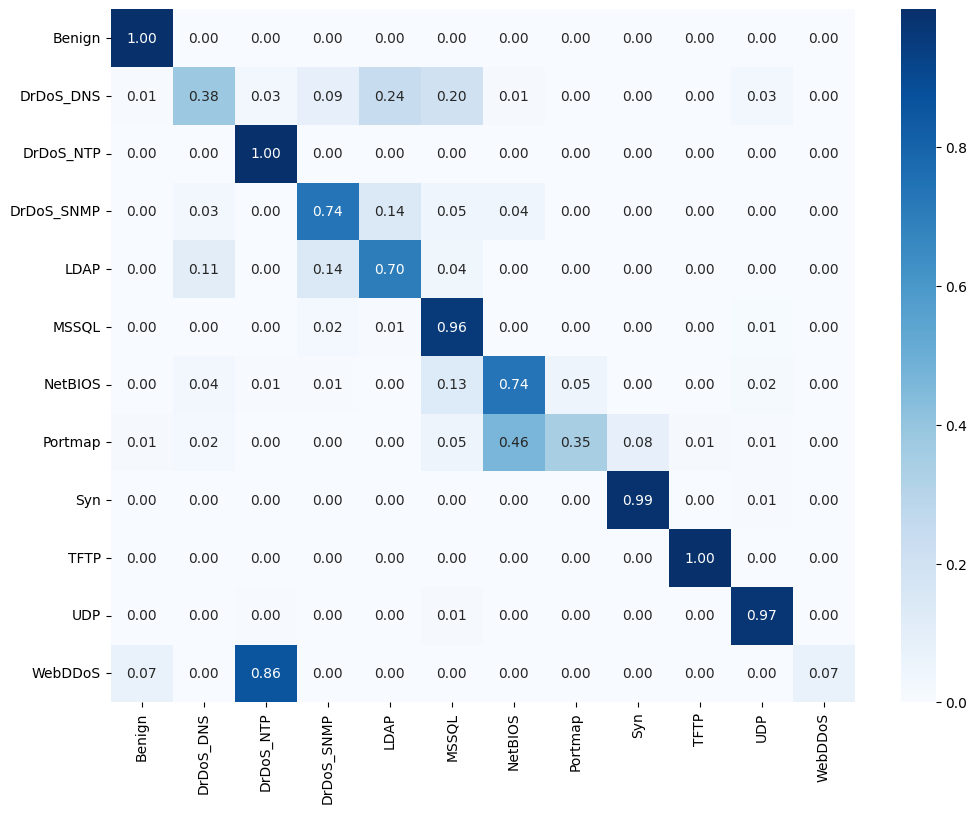

In [ ]:
# Matriz Normalizada
plt.figure(figsize=(12,9))
cm=confusion_matrix(y_test, y_model)
# Proceso de normalización
cm_normalized= cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized,annot=True, fmt=".2f", cmap="Blues", xticklabels=le.classes_,yticklabels=le.classes_)

# 4. Comentarios Finales

No obstante, el problema principal de este tipo de análisis es la explicabilidad de las variables, ya que cada modelo tiene una forma diferente de establecerla. Aunque existen herramientas como [SHAP](https://shap.readthedocs.io/en/latest/), el volumen de información utilizada para el entrenamiento impide el uso efectivo de esta metodología.

Adicional, el uso de este sistema no permite tener una precisión, recall y f1-score que supere lo obtenido por el modelo de XGBoost en solitario, por lo que el siguiente paso será la construcción de un modelo a partir de redes neuronales para identificar si se puede mejorar la precisión.

Finalmente, considerando los resultados de los tipos de ataque con menos registros, se evaluará la posibilidad de realización de dos modelos diferentes para cada conjunto de estos ataques, y verificar si esto mejora la predicción en estos casos